In [2]:
include("trion-solver.jl")
include("arpes-makie.jl")

white_gradience (generic function with 1 method)

In [18]:
σ = 20fs
m_h = 0.21
m_e = 0.37
E_g = 2.84
ϵ = 6.4
E_B = -0.1
hexagonal_edge = 4π / (3 * 3.144817974)
w = hexagonal_edge
β = 1
a = 10.3
b = 25.2
kx_points = LinRange(-0.7, 1.7, 100)
ky_points = LinRange(-0.7, 1.7, 100)
dkx = step(kx_points)
dky = step(ky_points)
dk = dkx * dky
k_points = map(t -> SVector{2, Float64}(collect(t)),
    collect(Iterators.product(kx_points, ky_points))
)
ω_points = LinRange(0, 3, 500)
P_Tx = 1.2 * w
P_T = SVector{2, Float64}([P_Tx, 0.0]) 

ϵ_v2(k) =  - norm(k - w)^2 / 2m_h * inv_eV
ϵ_v1(k) =  - norm(k)^2     / 2m_h * inv_eV
ϵ_c(k)  =    norm(k)^2     / 2m_e * inv_eV + E_g
E_SP(P) = inv_eV * norm(P .- w)^2 / 2M .+ E_B .+ E_g

M = 2m_h + m_e

ham = IndirectTwoBandModel2D(m_e, m_h, E_g, SVector{2, Float64}([w, 0.0]))
dielectric = Dielectric2D(ϵ)
broadening(x) = @fastmath exp(- σ^2 * x^2)

broadening (generic function with 1 method)

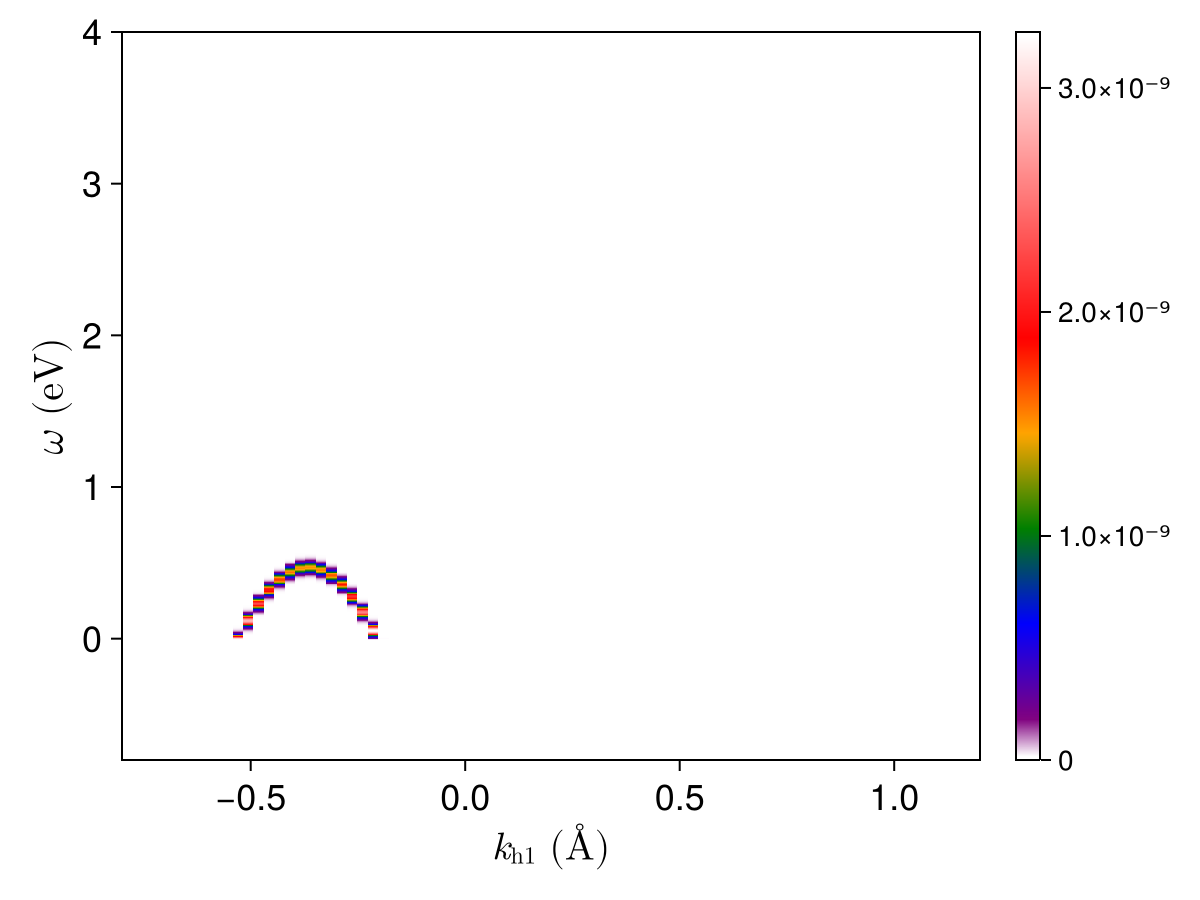

In [23]:
m_e = ham.m_e
m_h = ham.m_h
E_g = ham.E_g
M = 2m_h + m_e
w = ham.w

E_S_PT = inv_eV * (P_T - w)' * (P_T - w) / 2M
A_SQ_k1k2 = phi1sa1sb(IndirectTwoBandMat2D(ham, dielectric), a, b)

k_e = SVector{2, Float64}([1.0, 0.0])

# The contributions of (various values of) kh1 and ω to the ARPES spectrum
# when ke is fixed to a given value.
Akh1ω_ke = map(Iterators.product(kx_points, ω_points)) do (k_h1x, ω) 
    k_h1 = SVector{2, Float64}([k_h1x, 0.0])
    k_h2 = P_T - k_e - k_h1
    ϵ_v_kh1 = - inv_eV * k_h1' * k_h1 / 2m_h
    ϵ_v_kh2 = - inv_eV * (k_h2 - w)' * (k_h2 - w) / 2m_h

    δ_factor = broadening(ω - E_S_PT - ϵ_v_kh1 - ϵ_v_kh2 - E_B - E_g)
    
    k_1 = k_h1 + m_h / M * w - m_h / M * P_T
    k_2 = k_h2 - (m_h + m_e) / M * w - m_h / M * P_T
    trion_structure_factor = abs(A_SQ_k1k2(k_1, k_2))^2
    
    δ_factor * trion_structure_factor
end

fig = Figure()
ax_heatmap = Axis(fig[1, 1], 
    xlabel = L"$k_{\mathrm{h1}}$ (Å)", 
    ylabel = L"$ω$ (eV)",
    xlabelsize = 20,
    ylabelsize = 20,
    xticklabelsize = 18,
    yticklabelsize = 18,
)

heatmap!(ax_heatmap, kx_points, ω_points, Akh1ω_ke,
    colormap = arpes_colormap(transparency_gradience),
)

ylims!(ax_heatmap, (-0.8, 4))
xlims!(ax_heatmap, (-0.8, 1.2))
hidedecorations!(ax_heatmap, ticks = false, ticklabels = false, label = false)

Colorbar(fig[1, 2], 
    colormap = arpes_colormap(transparency_gradience),
    colorrange = (minimum(Akh1ω_ke), maximum(Akh1ω_ke))
)

fig